<a href="https://colab.research.google.com/github/kunwarsaaim/pytorch_geometric/blob/master/QSAR_molecular_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation


In [2]:
!pip install torch==1.4.0 torchvision==0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
!python -c "import torch; print(torch.__version__)"
!python -c 'import torch; print(torch.cuda.is_available())'

1.4.0
True


In [0]:
! PATH=/usr/local/cuda/bin:$PATH
! CPATH=/usr/local/cuda/include:$CPATH    
! LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH
! DYLD_LIBRARY_PATH=/usr/local/cuda/lib:$DYLD_LIBRARY_PATH

In [5]:
! nvcc --version
! python -c "import torch; print(torch.version.cuda)"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
10.1


In [0]:
!CUDA=cu101

In [7]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 10.6MB 6.8MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 15.2MB 208kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 14.5MB 1.9MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 5.1MB 6.8MB/s 
     |████████████████████████████████| 133kB 4.9MB/s 
     |████████████████████████████████| 235kB 15.9MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.4.3-cp36-none-any.whl size=234873 sha256=b07e9ab3500fa2e60b1489cc2fe8cae26407ff8880339736e1d16ce9d70ac250
  Stored in directory: /root/.cache/pip/wheels/e2/c1/09/8693feee3f97e440d68b09abfca8b4c1e97150ace350b5003f
Successfully built torch-geometric


In [8]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-04-22 12:37:34--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-04-22 12:37:34--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M  56.0MB/s    in 1.4s    

2020-04-22 12:37:36 (56.0 MB/s) - ‘Miniconda3-latest-Linu

In [0]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

# Mol To Graph (DeepChem)

In [0]:
from __future__ import division
from __future__ import unicode_literals
import numpy as np
from rdkit import Chem
import multiprocessing
import logging
import torch
from torch_geometric.data import Data
 
# following code was borrowed from deepchem
# https://raw.githubusercontent.com/deepchem/deepchem/master/deepchem/feat/graph_features.py
 
 
def one_of_k_encoding(x, allowable_set):
  if x not in allowable_set:
    raise Exception("input {0} not in allowable set{1}:".format(
        x, allowable_set))
  return list(map(lambda s: x == s, allowable_set))
 
 
def one_of_k_encoding_unk(x, allowable_set):
  """Maps inputs not in the allowable set to the last element."""
  if x not in allowable_set:
    x = allowable_set[-1]
  return list(map(lambda s: x == s, allowable_set))
 
 
def get_intervals(l):
  """For list of lists, gets the cumulative products of the lengths"""
  intervals = len(l) * [0]
  # Initalize with 1
  intervals[0] = 1
  for k in range(1, len(l)):
    intervals[k] = (len(l[k]) + 1) * intervals[k - 1]
 
  return intervals
 
 
def safe_index(l, e):
  """Gets the index of e in l, providing an index of len(l) if not found"""
  try:
    return l.index(e)
  except:
    return len(l)
 
 
possible_atom_list = [
    'C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Mg', 'Na', 'Br', 'Fe', 'Ca', 'Cu',
    'Mc', 'Pd', 'Pb', 'K', 'I', 'Al', 'Ni', 'Mn'
]
possible_numH_list = [0, 1, 2, 3, 4]
possible_valence_list = [0, 1, 2, 3, 4, 5, 6]
possible_formal_charge_list = [-3, -2, -1, 0, 1, 2, 3]
possible_hybridization_list = [
    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
possible_number_radical_e_list = [0, 1, 2]
possible_chirality_list = ['R', 'S']
 
reference_lists = [
    possible_atom_list, possible_numH_list, possible_valence_list,
    possible_formal_charge_list, possible_number_radical_e_list,
    possible_hybridization_list, possible_chirality_list
]
 
intervals = get_intervals(reference_lists)
 
 
def get_feature_list(atom):
  features = 6 * [0]
  features[0] = safe_index(possible_atom_list, atom.GetSymbol())
  features[1] = safe_index(possible_numH_list, atom.GetTotalNumHs())
  features[2] = safe_index(possible_valence_list, atom.GetImplicitValence())
  features[3] = safe_index(possible_formal_charge_list, atom.GetFormalCharge())
  features[4] = safe_index(possible_number_radical_e_list,
                           atom.GetNumRadicalElectrons())
  features[5] = safe_index(possible_hybridization_list, atom.GetHybridization())
  return features
 
 
def features_to_id(features, intervals):
  """Convert list of features into index using spacings provided in intervals"""
  id = 0
  for k in range(len(intervals)):
    id += features[k] * intervals[k]
 
  # Allow 0 index to correspond to null molecule 1
  id = id + 1
  return id
 
 
def id_to_features(id, intervals):
  features = 6 * [0]
 
  # Correct for null
  id -= 1
 
  for k in range(0, 6 - 1):
    # print(6-k-1, id)
    features[6 - k - 1] = id // intervals[6 - k - 1]
    id -= features[6 - k - 1] * intervals[6 - k - 1]
  # Correct for last one
  features[0] = id
  return features
 
 
def atom_to_id(atom):
  """Return a unique id corresponding to the atom type"""
  features = get_feature_list(atom)
  return features_to_id(features, intervals)
 
 
def atom_features(atom,
                  bool_id_feat=False,
                  explicit_H=False,
                  use_chirality=False):
  if bool_id_feat:
    return np.array([atom_to_id(atom)])
  else:
    from rdkit import Chem
    results = one_of_k_encoding_unk(
      atom.GetSymbol(),
      [
        'C',
        'N',
        'O',
        'S',
        'F',
        'Si',
        'P',
        'Cl',
        'Br',
        'Mg',
        'Na',
        'Ca',
        'Fe',
        'As',
        'Al',
        'I',
        'B',
        'V',
        'K',
        'Tl',
        'Yb',
        'Sb',
        'Sn',
        'Ag',
        'Pd',
        'Co',
        'Se',
        'Ti',
        'Zn',
        'H',  # H?
        'Li',
        'Ge',
        'Cu',
        'Au',
        'Ni',
        'Cd',
        'In',
        'Mn',
        'Zr',
        'Cr',
        'Pt',
        'Hg',
        'Pb',
        'Unknown'
      ]) + one_of_k_encoding(atom.GetDegree(),
                             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + \
              one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
              [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
              one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
              ]) + [atom.GetIsAromatic()]
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
      results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                [0, 1, 2, 3, 4])
    if use_chirality:
      try:
        results = results + one_of_k_encoding_unk(
            atom.GetProp('_CIPCode'),
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
      except:
        results = results + [False, False
                            ] + [atom.HasProp('_ChiralityPossible')]
 
    return np.array(results)
 
 
def bond_features(bond, use_chirality=False):
  from rdkit import Chem
  bt = bond.GetBondType()
  bond_feats = [
      bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
      bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
      bond.GetIsConjugated(),
      bond.IsInRing()
  ]
  if use_chirality:
    bond_feats = bond_feats + one_of_k_encoding_unk(
        str(bond.GetStereo()),
        ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
  return np.array(bond_feats)
 
#################
# pen added
#################
def get_bond_pair(mol):
  bonds = mol.GetBonds()
  res = [[],[]]
  for bond in bonds:
    res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
    res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
  return res
 
def mol2vec(mol):
  atoms = mol.GetAtoms()
  bonds = mol.GetBonds()
  node_f= [atom_features(atom) for atom in atoms]
  edge_index = get_bond_pair(mol)
  edge_attr = [bond_features(bond, use_chirality=False) for bond in bonds]
  for bond in bonds:
    edge_attr.append(bond_features(bond))
  data = Data(x=torch.tensor(node_f, dtype=torch.float),
              edge_index=torch.tensor(edge_index, dtype=torch.long),
              edge_attr=torch.tensor(edge_attr,dtype=torch.float)
              )
  return data

In [11]:
%%bash
wget https://raw.githubusercontent.com/rdkit/rdkit/master/Docs/Book/data/solubility.train.sdf
wget https://raw.githubusercontent.com/rdkit/rdkit/master/Docs/Book/data/solubility.test.sdf

--2020-04-22 12:38:50--  https://raw.githubusercontent.com/rdkit/rdkit/master/Docs/Book/data/solubility.train.sdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1376487 (1.3M) [text/plain]
Saving to: ‘solubility.train.sdf’

     0K .......... .......... .......... .......... ..........  3% 3.19M 0s
    50K .......... .......... .......... .......... ..........  7% 7.58M 0s
   100K .......... .......... .......... .......... .......... 11% 17.7M 0s
   150K .......... .......... .......... .......... .......... 14% 10.8M 0s
   200K .......... .......... .......... .......... .......... 18% 18.2M 0s
   250K .......... .......... .......... .......... .......... 22% 18.5M 0s
   300K .......... .......... .......... .......... .......... 26% 13.9M 0s
   350K ........

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.data import DataLoader
from torch_scatter import scatter_mean
#import mol2graph
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
 
plt.style.use("ggplot")
 
train_mols = [m for m in Chem.SDMolSupplier('/content/solubility.train.sdf')]
test_mols = [m for m in Chem.SDMolSupplier('/content/solubility.train.sdf')]
sol_cls_dict = {'(A) low':0, '(B) medium':1, '(C) high':2}


In [0]:
train_X = [mol2vec(m) for m in train_mols]
for i, data in enumerate(train_X):
    y = sol_cls_dict[train_mols[i].GetProp('SOL_classification')]
    data.y = torch.tensor([y], dtype=torch.long)
 
test_X = [mol2vec(m) for m in test_mols]
for i, data in enumerate(test_X):
    y = sol_cls_dict[test_mols[i].GetProp('SOL_classification')]
    data.y = torch.tensor([y], dtype=torch.long)
train_loader = DataLoader(train_X, batch_size=128, shuffle=True, drop_last=True)
test_loader = DataLoader(test_X, batch_size=128, shuffle=True, drop_last=True)


# Model

In [0]:
n_features = 75

class Net(torch.nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    self.conv1 = GCNConv(n_features,128)
    self.bn1 = BatchNorm1d(128)
    self.conv2 = GCNConv(128,64)
    self.bn2 = BatchNorm1d(64)
    self.fc1 = Linear(64,64)
    self.bn3 = BatchNorm1d(64)
    self.fc2 = Linear(64,64)
    self.fc3 = Linear(64,3)
  
  def forward(self,data):
    x,edge_index = data.x,data.edge_index
    x = F.relu(self.conv1(x,edge_index))
    x = self.bn1(x)
    x = F.relu(self.conv2(x,edge_index))
    x = self.bn2(x)
    x = global_add_pool(x,data.batch)
    x = F.relu(self.fc1(x))
    x = self.bn3(x)
    x = F.relu(self.fc2(x))
    x = F.dropout(x,p=0.2,training=self.training)
    x = self.fc3(x)
    x = F.log_softmax(x,dim=1)
    return x

Epoch: 1, Train loss: 0.853, Train_acc: 0.516, Test_acc: 0.515
Epoch: 2, Train loss: 0.652, Train_acc: 0.599, Test_acc: 0.6
Epoch: 3, Train loss: 0.494, Train_acc: 0.565, Test_acc: 0.565
Epoch: 4, Train loss: 0.465, Train_acc: 0.749, Test_acc: 0.748
Epoch: 5, Train loss: 0.425, Train_acc: 0.735, Test_acc: 0.735
Epoch: 6, Train loss: 0.423, Train_acc: 0.824, Test_acc: 0.824
Epoch: 7, Train loss: 0.344, Train_acc: 0.855, Test_acc: 0.855
Epoch: 8, Train loss: 0.349, Train_acc: 0.852, Test_acc: 0.852
Epoch: 9, Train loss: 0.341, Train_acc: 0.807, Test_acc: 0.807
Epoch: 10, Train loss: 0.319, Train_acc: 0.877, Test_acc: 0.877
Epoch: 11, Train loss: 0.31, Train_acc: 0.877, Test_acc: 0.877
Epoch: 12, Train loss: 0.299, Train_acc: 0.834, Test_acc: 0.834
Epoch: 13, Train loss: 0.271, Train_acc: 0.874, Test_acc: 0.874
Epoch: 14, Train loss: 0.264, Train_acc: 0.854, Test_acc: 0.854
Epoch: 15, Train loss: 0.342, Train_acc: 0.865, Test_acc: 0.865
Epoch: 16, Train loss: 0.257, Train_acc: 0.899, Test

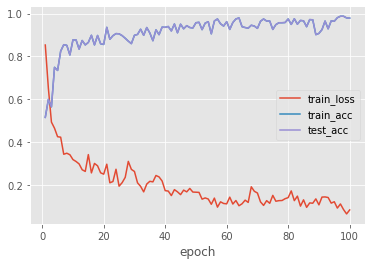

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_X)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)
hist = {"loss":[], "acc":[], "test_acc":[]}

for epoch in range(1, 101):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    hist["loss"].append(train_loss)
    hist["acc"].append(train_acc)
    hist["test_acc"].append(test_acc)
    print(f'Epoch: {epoch}, Train loss: {train_loss:.3}, Train_acc: {train_acc:.3}, Test_acc: {test_acc:.3}')
ax = plt.subplot(1,1,1)
ax.plot([e for e in range(1,101)], hist["loss"], label="train_loss")
ax.plot([e for e in range(1,101)], hist["acc"], label="train_acc")
ax.plot([e for e in range(1,101)], hist["test_acc"], label="test_acc")
plt.xlabel("epoch")
ax.legend()